# Example 3: Quantum Scar Dynamics


This example will show the dynamics of quantum many-body scar, and follow example 4. Let us begin by importing the requisite packages. You can run these locally by running ```pip install amazon-braket-sdk``` and ``` pip install quera-ahs-utils```. For more details, see https://github.com/aws/amazon-braket-sdk-python and https://github.com/QuEraComputing/quera-ahs-utils.

In [18]:
from braket.ahs.driving_field import DrivingField
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.aws import AwsDevice, AwsQuantumTask

import quera_ahs_utils.drive as drive
import quera_ahs_utils.ir as ir

import numpy as np
import json, os



RAMP_TIME = 0.06e-6
MIN_TIME_STEP = 0.05e-6

def batch_submit(qpu: AwsDevice, ahs_programs: list, json_output_filename: str, shots: int=100):
    """
    Submits a batch of jobs to AWS BraKet, and save associated data to file.
    """
    
    def submit_and_report(qpu: AwsDevice, ahs_program: AnalogHamiltonianSimulation, metadata):
        discretize_ahs_program = ahs_program.discretize(qpu)
        task = qpu.run(discretize_ahs_program, shots=shots)
        ahs_ir = discretize_ahs_program.to_ir()
        arn = task._arn
        task_bundle = {
            "task":eval(ahs_ir.json()),
            "metadata":str(metadata) # use eval to free data. 
        }
    
        return arn,task_bundle
    
    if not os.path.isfile(json_output_filename): # prevent accidental resubmission. 
        tasks = {}
        for ahs_program,*metadata in ahs_programs:
            try:
                arn, task_bundle = submit_and_report(qpu, ahs_program, metadata)
                tasks[arn] = task_bundle
            except BaseException as e: 
                print(ahs_program.to_ir().json(
                    indent=2,
                ))
                for arn in tasks:
                    AwsQuantumTask(arn).cancel()
                raise e
            
        with open(json_output_filename,"w") as IO:
            json.dump(tasks,IO,indent=2)
    else:
        raise RuntimeError("resubmitting jobs not allowed, please use different filename.")

The waveform in this example contains two parts: the first is the adiabatic preparation of Z2 state, similar to Examaple 3.  The second part is for the quantum scar 
dynamics, where the detuning is zero, while the Rabi drive has finite value. 

In [2]:
import quera_ahs_utils.plotting as plotting

def rabi_pulse_sequence(run_time: float, rabi_value: float, deutning_value: float) -> DrivingField:
    times = [0, RAMP_TIME, run_time + RAMP_TIME, run_time + 2 * RAMP_TIME]
    amplitude_values = [0, rabi_value, rabi_value, 0]
    detuning_values = [0, deutning_value, deutning_value, 0]
    phase_values = [0, 0, 0, 0]
    return drive.get_drive(times, amplitude_values, detuning_values, phase_values)


# construct the total waveform with adiabatic preparation part and the scar evolution part 

def quantum_scar_sequence_global(run_time: float):
    Delta_start = -18.8e6
    Delta_end = 16.3e6
    Omega_max = 15.7e6
    prep = drive.adiabatic_drive(
        t_ramp_up = 0.3e-6, 
        t_ramp_down = 0.3e-6, 
        t_sweep = 1.6e-6, 
        Omega_max = Omega_max, 
        Delta_start = Delta_start, 
        Delta_end = Delta_end
    )
    
    ramp_up = 0.2e-6
    evolve_time = 1.8e-6 - 2*ramp_up
    amplitude = drive.time_series(
            times=[0.0, ramp_up, evolve_time+ramp_up, evolve_time+2*ramp_up], 
            values=[0.0, Omega_max, Omega_max, 0.0]
        )
    
    detuning = drive.time_series(
            times=[0.0, ramp_up, evolve_time+2*ramp_up], 
            values=[Delta_end, 0.0, 0.0]
        )
    
    evolve = DrivingField(
        amplitude = amplitude,
        detuning = detuning,
        phase = drive.constant_time_series(amplitude, 0.0)
    )
    
    total_drive = drive.concatenate_drives(prep,evolve)

    sliced_drive = drive.slice_drive(total_drive,0.0,run_time, min_time_step=MIN_TIME_STEP)
    
    drive_values = drive.get_driving_field_values(total_drive, run_time)
    
    t_truncate = min(0.065e-6, 4e-6-run_time)
    
    if t_truncate > 0.0:
        drive_truncate = DrivingField(
            amplitude=drive.time_series([0,t_truncate],[drive_values.amplitude, 0]),
            detuning=drive.time_series([0,t_truncate],[drive_values.detuning, 0]),
            phase=drive.time_series([0,t_truncate],[drive_values.phase, drive_values.phase])
        )
        return drive.concatenate_drives(sliced_drive, drive_truncate)
    elif t_truncate == 0.0:
        return total_drive
    else:
        raise ValueError("run_time larger than 4.0e-6 seconds.")


# 1D chain of atoms, with 6.1 um distance between nearby atoms 
def quantum_scar_program(run_time: float):
    register = AtomArrangement()
    for i in range(11):
        register.add((0,6.1e-6*i))
        
    return AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=quantum_scar_sequence_global(run_time)
    )


# total run time includes two parts 

prep_times = np.around(np.arange(0.2e-6,2.2e-6,0.2e-6),13) 
scar_times = np.around(np.arange(2.2e-6,4.01e-6,0.01e-6),13)
run_times = np.unique(np.hstack((prep_times, scar_times)))


# construct tasks that end up different run time
global_scar_sim_programs = []

for run_time in run_times:
    try:
        global_scar_sim_programs.append((quantum_scar_program(run_time), run_time))
    except ValueError:
        pass


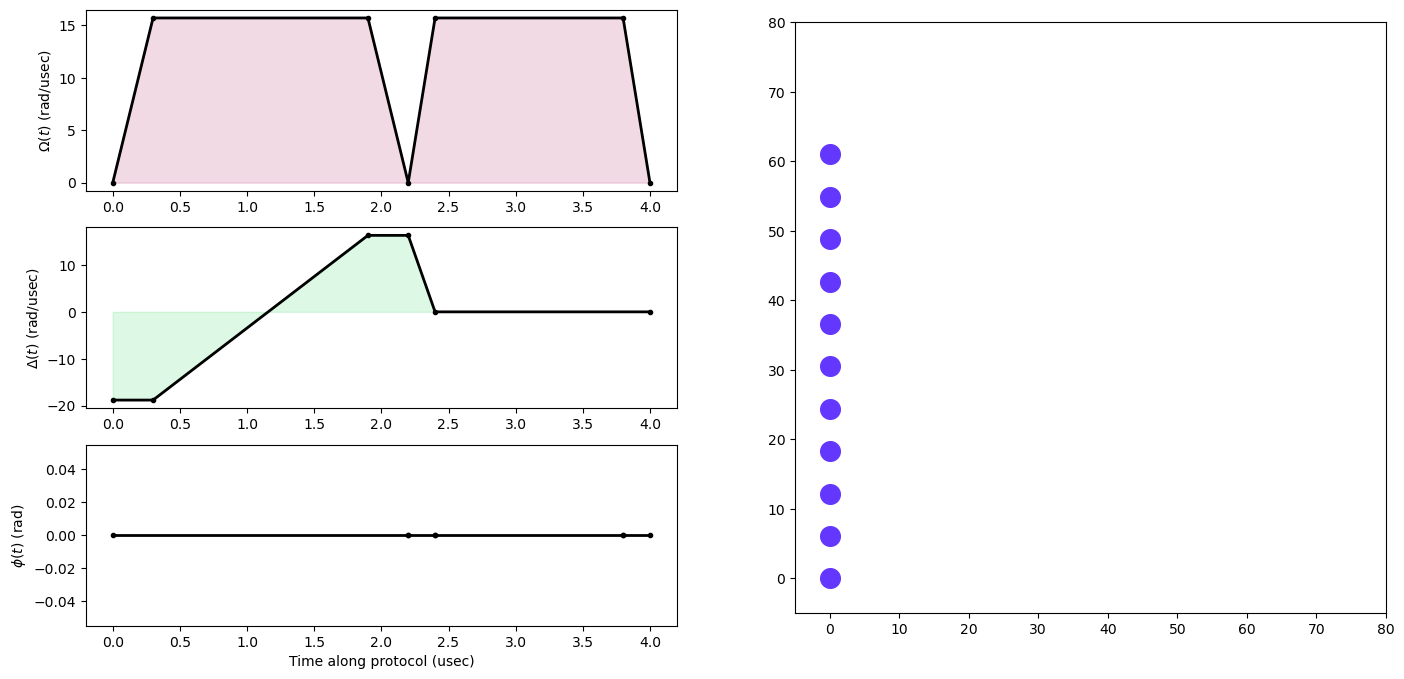

In [11]:
from quera_ahs_utils.plotting import plot_task
plot_task( global_scar_sim_programs[-1][0] ,show_register=True)

Run the simulation with classcial simulator. 

In [4]:
# WARNING: this cell takes a long time to run. 
from braket.devices import LocalSimulator
import tqdm

sim = LocalSimulator("braket_ahs")
global_scar_sim_tasks = []

for scar_sim_program,*params in tqdm.tqdm(global_scar_sim_programs):
    global_scar_sim_task = sim.run(scar_sim_program, shots=10000)
     
    global_scar_sim_tasks.append((global_scar_sim_task, None)+tuple(params))


  1%|          | 2/176 [00:03<05:11,  1.79s/it]capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/braket-examples-debugging/lib/python3.11/site-packages/braket/analog_hamiltonian_simulator/rydberg/scipy_solver.py", line 82, in f
    return -1j * dt * _apply_hamiltonian(index_time, operators_coefficients, y)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/braket-examples-debugging/lib/python3.11/site-packages/braket/analog_hamiltonian_simulator/rydberg/rydberg_simulator_helpers.py", line 566, in _apply_hamiltonian
    output_register += (rabi_coef[index_time] / 2) * rabi_op.dot(input_register)
                        ~~~~~~~~~^^^^^^^^^^^^
IndexError: index 1000 is out of bounds for axis 0 wit

: 

: 

Submit the jobs to QPU, with parallelization of multiple column of atoms

In [16]:
import quera_ahs_utils.parallelize as pp

qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)

global_scar_qpu_programs = [pp.parallelize_ahs(global_scar_sim_program,qpu,24e-6)+(run_time,) for global_scar_sim_program,run_time in global_scar_sim_programs]

In [19]:
#raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, global_scar_qpu_programs, "global_scar_dynamics.json", shots=100)

{
  "braketSchemaHeader": {
    "name": "braket.ir.ahs.program",
    "version": "1"
  },
  "setup": {
    "ahs_register": {
      "sites": [
        [
          "0.0",
          "0.0"
        ],
        [
          "0.0",
          "0.0000061"
        ],
        [
          "0.0",
          "0.0000122"
        ],
        [
          "0.0",
          "0.0000183"
        ],
        [
          "0.0",
          "0.0000244"
        ],
        [
          "0.0",
          "0.0000305"
        ],
        [
          "0.0",
          "0.0000366"
        ],
        [
          "0.0",
          "0.0000427"
        ],
        [
          "0.0",
          "0.0000488"
        ],
        [
          "0.0",
          "0.0000549"
        ],
        [
          "0.0",
          "0.000061"
        ],
        [
          "0.000024",
          "0.0"
        ],
        [
          "0.000024",
          "0.0000061"
        ],
        [
          "0.000024",
          "0.0000122"
        ],
        [
       

ValidationException: An error occurred (ValidationException) when calling the CreateQuantumTask operation: 1 validation error for DrivingFieldValidator
__root__
  Time points of amplitude time_series, 3 (0.000002200) and 4 (0.000002210), are too close; they are separated by 1.0E-8 seconds. It must be at least 5E-8 seconds (type=value_error)

In [7]:
from braket.aws import AwsQuantumTask
import json

global_scar_qpu_tasks = []
with open("global_scar_dynamics.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping, run_time = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        global_scar_qpu_tasks.append((task, batch_mapping, run_time))

FileNotFoundError: [Errno 2] No such file or directory: 'global_scar_dynamics.json'

Colllect and process data from both (classical) local simulator and QPU. 

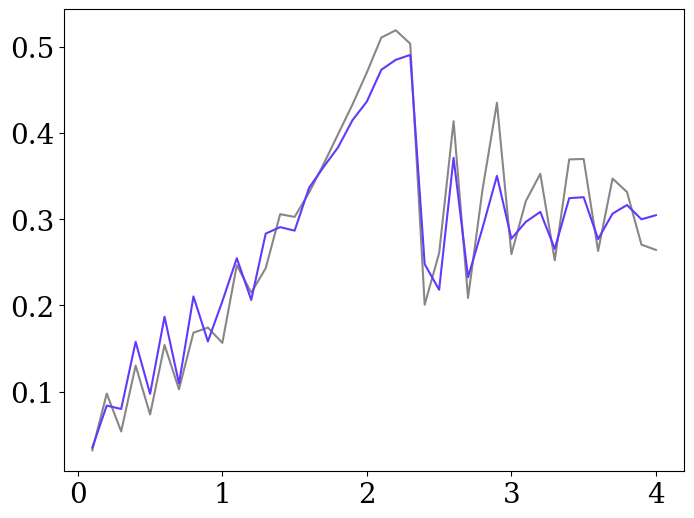

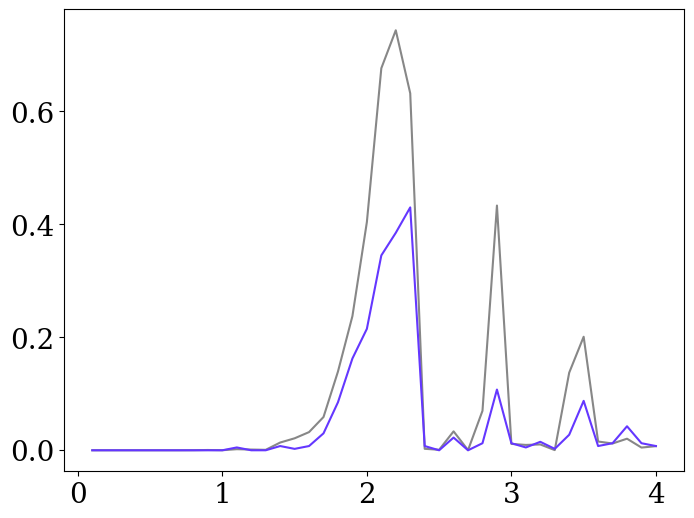

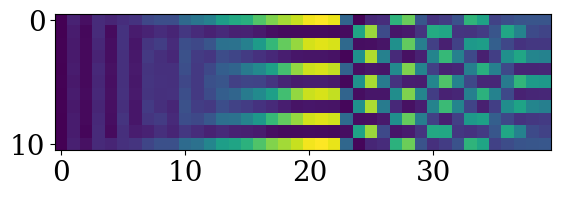

In [9]:
import matplotlib.pyplot as plt
from itertools import starmap
import quera_ahs_utils.parallelize as pp

plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

def get_densities(task, batch_mapping, run_time):
    shots = pp.get_shots_braket_sdk_results(task.result(), batch_mapping=batch_mapping, post_select=False)
    
    neel_state = np.ones(shots.shape[1],dtype=int)
    neel_state[0::2] = 0

    is_ground_state = [np.all(shot==neel_state) for shot in shots[:]]
    densities = 1-shots.mean(axis=0)
    
    return run_time/1e-6, np.mean(is_ground_state), densities

# qpu_results = list(starmap(get_densities,global_scar_qpu_tasks))
sim_results = list(starmap(get_densities,global_scar_sim_tasks))

# qpu_results = sorted(qpu_results,key=lambda x:x[0])
sim_results = sorted(sim_results,key=lambda x:x[0])

# run_times,qpu_ground_state_prob,qpu_density = zip(*qpu_results)
run_times,sim_ground_state_prob,sim_density = zip(*sim_results)

# qpu_density = np.array(qpu_density)
sim_density = np.array(sim_density)


RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

plt.figure(figsize=(8,6))
plt.plot(run_times,sim_density.mean(axis=1),color=BLACK)
plt.plot(run_times,qpu_density.mean(axis=1),color=PURPLE)

plt.show()

plt.figure(figsize=(8,6))
plt.plot(run_times,sim_ground_state_prob,color=BLACK)
plt.plot(run_times,qpu_ground_state_prob,color=PURPLE)

plt.show()

plt.imshow(sim_density.T)

plt.show()
